In [1]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from amftrack.util.dbx import (upload
)
%load_ext autoreload
%autoreload 2
%matplotlib widget

from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    Edge,
    Node,

)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    reconstruct_image_from_general,
    plot_full,
    plot_edge_color_value,
)
from amftrack.transport.align_video_network import identify_nodes
logging.basicConfig(stream=sys.stdout, level=logging.debug)
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
mpl.rcParams["figure.dpi"] = 100
from amftrack.pipeline.functions.transport_processing.high_mag_videos.loading import load_video_dataset

from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
import networkx as nx
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import *

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [67]:
directory_targ = r"C:\Users\coren\Documents\temp_441/"


plate_id = "441_20230807"

update_plate_info(directory_targ, local=True,strong_constraint=False)
all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_labeled2.p"] == True]
folders = folders.sort_values(by="folder")

plate_id_video = "20230811_Plate441"
folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
# i = indexes[plate_id_video]
# i = np.where(folders['folder'] == indexes[plate_id_video])[0][0]
# selection = folders[folders['folder'].isin(indexes.values())]
i = 0
exp.load(folders.iloc[i : i + 2], suffix="_labeled2")
# exp.load(selection, suffix="_labeled")

for t in range(exp.ts):
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)

# load_graphs(exp, directory_targ,indexes = [0])
    edges = get_all_edges(exp, t)

    weights = {(edge.begin.label, edge.end.label): edge.length_um(t) for edge in edges}
    nx.set_edge_attributes(exp.nx_graph[t], weights, "length")
    G = exp.nx_graph[t]
    components = nx.connected_components(G)

    # Find the largest connected component
    largest_component = max(components, key=len)

    # Create a new graph representing the largest connected component
    largest_component_graph = G.subgraph(largest_component)
    exp.nx_graph[t] = largest_component_graph

analysed:   0%|          | 0/2 [00:00<?, ?it/s]

2023-08-11 16:05:00
2023-08-12 02:05:00


In [68]:
import pickle
path_save = "node_source.p"

(nodes_source, nodes_exp) = pickle.load(open(path_save, "rb"))

In [70]:
t=0
nodes = get_all_nodes(exp,t)

# nodes_source,nodes_exp = get_nodes_source_C(exp)
# nodes_source = [node for node in nodes if is_in_ROI_node(node, t) and node.degree(t)==1]
nodes_sink = [node for node in nodes]
nodes_sink = find_lowest_nodes(nodes_sink, t,num = 10)

In [106]:
G = exp.nx_graph[t] 
GD = nx.DiGraph()  # Example graph, replace it with your actual graph object
v0 = 3 #um.s-1
factor = 1000
reff = 3 #um
# Add edges based on shortest path comparison
for u, v, data in G.edges(data=True):
    GD.add_edge(v, u, **data)
    GD.add_edge(u, v, **data)
    data['capacity'] = int(np.pi*data['width']**2/4*v0*factor)*len(nodes_sink)
tot_demand = 0
for node in nodes_source:
    demand = int(np.pi*nodes_exp[node]*reff**2*factor*0.3/3600)*len(nodes_sink)
    GD.add_node(node.label,demand = demand)
    tot_demand+= demand
sink_demand = -tot_demand//len(nodes_sink)
for node in nodes_sink:
    GD.add_node(node.label,demand = sink_demand)

In [111]:
# flow_dict = nx.min_cost_flow(GD,weight="length")
flow_dict = nx.capacity_scaling(GD,weight="length")

536870912



KeyboardInterrupt



In [38]:

t = 0
index = np.argmax([nodes_exp[node] for node in nodes_source])
node2 = nodes_source[index]
G = exp.nx_graph[t] 
shortest_length = nx.shortest_path_length(
    exp.nx_graph[t], node2.label, weight="length"
)
w = nodes_exp[node2]
GD = nx.DiGraph()  # Example graph, replace it with your actual graph object
# Your anchor node, specify the correct label
anchor_node = 'anchor_label'

# Compute shortest path lengths from all nodes to the anchor node
# Create a new directed graph where edges are oriented based on path lengths
new_graph = nx.DiGraph()

# Add edges based on shortest path comparison
for u, v, data in GD.edges(data=True):
    if shortest_length[u] > shortest_length[v]:
        # If u is farther from the anchor than v, add edge v -> u
        new_graph.add_edge(v, u, **data)
    else:
        # If v is farther, or they are equidistant, add edge u -> v
        new_graph.add_edge(u, v, **data)
for u, v in G.edges():
    orientation = 1 - 2 * (shortest_length[u] > shortest_length[v])
    orientation *= (1-2 * (u > v))
    if orientation>0:
        G[u][v]["QBC_p"] = 1  # Attribute for edge from A to B
        G[u][v]["QBC_m"] = 0  # Attribute for edge from A to B

    else:
        G[u][v]["QBC_m"] = 1
        G[u][v]["QBC_p"] = 0  # Attribute for edge from A to B

exp.nx_graph[t] = G


In [39]:
for edge in G.edges:
    G[edge[0]][edge[1]]["QBC_net"] = G[edge[0]][edge[1]]["QBC_p"]-G[edge[0]][edge[1]]["QBC_m"]
    G[edge[0]][edge[1]]["QBC_tot"] = G[edge[0]][edge[1]]["QBC_p"]+G[edge[0]][edge[1]]["QBC_m"]    

In [22]:
import matplotlib.patches as patches
def show_region(region,ax,downsizing = 5):
    adjusted_region = [[coord / downsizing for coord in point] for point in region]

    # Display the image (assuming 'image' is your loaded image)
    # ax.imshow(image)

    # Calculate rectangle parameters
    x0, y0 = adjusted_region[0]  # Lower-left corner
    x1, y1 = adjusted_region[1]  # Upper-right corner
    print(x0,y0,x1,y1)
    # Create a rectangle patch
    rect = patches.Rectangle((y0, x0), y1 - y0, x1 - x0, linewidth=2, edgecolor='r', facecolor='none',alpha = 0.8)
    ax.add_patch(rect)

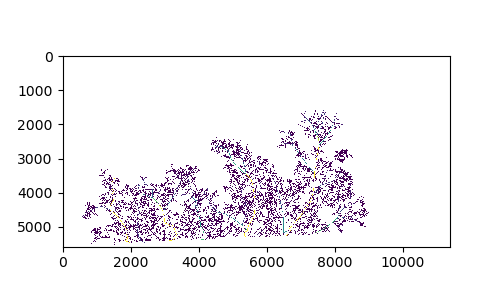

1500.0 6800.0 2200.0 7800.0
3200.0 6800.0 3900.0 7800.0
3650.0 5450.0 4350.0 6450.0
4500.0 5000.0 5200.0 6000.0


In [212]:
from matplotlib import cm

t=0
fig, ax,f = plot_edge_color_value_2(
    exp,
    t,
    lambda edge : abs(edge.get_attribute("QBC_tot",t)),
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    v_min = 0,
    v_max = 3000

)

regions = [[[1500*downsizing,6800*downsizing],[2200*downsizing,7800*downsizing]],
           [[3200*downsizing,6800*downsizing],[3900*downsizing,7800*downsizing]],
           [[3650*downsizing,5450*downsizing],[4350*downsizing,6450*downsizing]],
           [[4500*downsizing,5000*downsizing],[5200*downsizing,6000*downsizing]]
          ]
for region in regions:
    show_region(region,ax)

plt.xticks([])  # Removes 
plt.yticks([])  # Removes x-ti
path_fig = r"C:\Users\coren\Documents\PhD\paper\transport\Fig2"
plt.savefig(
    os.path.join(path_fig,"network_region.pdf"),
    transparent=True,
    bbox_inches="tight",
)

# plot_region(region)

In [40]:
def plot_arrows_along_edge(ax, begin, end, color, spacing=60):
    # Calculate the vector and its magnitude
    vector = end - begin
    distance = np.linalg.norm(vector)
    unit_vector = vector / distance

    # Calculate the number of arrows to create based on the spacing
    num_arrows = int(distance / spacing)
    if num_arrows<2:
        spacing= distance/2
        num_arrows = 1
    # Plot each arrow along the edge
    for i in range(1, num_arrows + 1):
        point = begin + unit_vector * (i * spacing)
        ax.annotate('', xytext=(point[1], point[0]), xy=(point[1] + unit_vector[1], point[0] + unit_vector[0]),
                    arrowprops=dict(arrowstyle="->", color=color))

In [41]:
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

t=0
downsizing = 5
def plot_region(region):
    fig, ax,f = plot_edge_color_value_2(
        exp,
        t,
        lambda edge : edge.get_attribute("QBC_tot",t),
        cmap=cm.get_cmap("viridis", 100),
        plot_cmap=True,
        show_background=False,
        dilation=10,
        figsize=(5, 3),
        alpha = 1,
        downsizing = downsizing,
        region = region,
        v_min = 0,
        v_max = 3000
    )
    edges_network = get_all_edges(exp,t)

    for edge in edges_network:
        pixels = edge.pixel_list(t)

        if is_in_bounding_box(pixels[0], region) or is_in_bounding_box(pixels[-1], region):
            if len(pixels) > 20:
                begin_arrow = f(pixels[20])
                end_arrow = f(pixels[-20])
                if edge.get_attribute("QBC_tot", t)>0:
                    relative_flux = edge.get_attribute("QBC_net", t) / edge.get_attribute("QBC_tot", t)
                    orientation = 1 - 2 * (relative_flux > 0)
                    orientation *= (2 * (edge.begin.label > edge.end.label)-1)
                    color = 'red'
                    edge_width = 1  # Adjust the width as needed
                    if orientation<0:
                        begin_arrow,end_arrow = end_arrow,begin_arrow
                    # if abs(relative_flux) > 0.5:
                    plot_arrows_along_edge(ax, begin_arrow, end_arrow, color)
    plt.xticks([])  # Removes 
    plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels

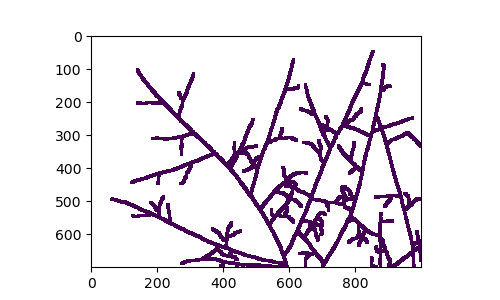

In [42]:
regions = [[[1500*downsizing,6800*downsizing],[2200*downsizing,7800*downsizing]],
           # [[3200*downsizing,6800*downsizing],[3900*downsizing,7800*downsizing]],
           # [[3650*downsizing,5450*downsizing],[4350*downsizing,6450*downsizing]],
           # [[4500*downsizing,5000*downsizing],[5200*downsizing,6000*downsizing]]
          ]
for i,region in enumerate(regions[:1]):
    plot_region(region)
    # break

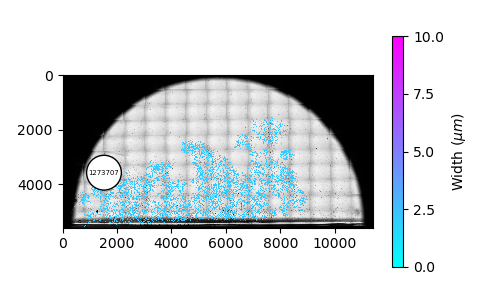

(<Figure size 500x300 with 2 Axes>, <AxesSubplot: >)

In [37]:
plot_edge_color_value(
    exp,
    t,
    lambda edge : 2,
    cmap=cm.get_cmap("cool", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    nodes = [node2]
)

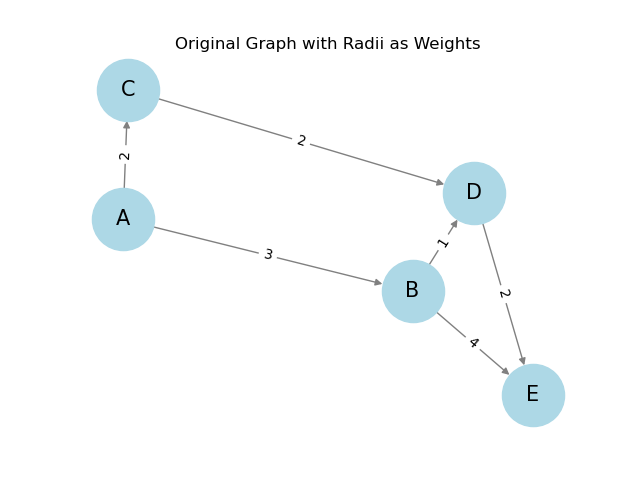

Edge flux values:
Edge ('A', 'B'): 60.0 units of flux
Edge ('A', 'C'): 40.0 units of flux
Edge ('B', 'D'): 12.0 units of flux
Edge ('B', 'E'): 48.0 units of flux
Edge ('C', 'D'): 40.0 units of flux
Edge ('D', 'E'): 52.0 units of flux


In [112]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque, defaultdict
fig,ax = plt.subplots()
# Create a directed graph
G = nx.DiGraph()
edges = [('A', 'B', 3), ('A', 'C', 2),('C', 'D', 2), ('B', 'D', 1), ('D', 'E', 2), ('B', 'E', 4)]
G.add_weighted_edges_from(edges, weight='radius')

# Initial flux at the anchor node
anchor_node = 'A'
initial_flux = 100  # The initial flux at the anchor node

# Visualize the initial graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=15)
labels = nx.get_edge_attributes(G, 'radius')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Original Graph with Radii as Weights')
plt.show()

# Initialize flux dictionary for each edge
edge_flux = {edge: None for edge in G.edges()}
node_incoming_edges = defaultdict(list)
for u, v in G.edges():
    node_incoming_edges[v].append((u, v))

# Initialize node flux and queue
node_flux = {node: 0 for node in G.nodes()}
node_flux[anchor_node] = initial_flux
queue = deque()
for _, target, data in G.out_edges(anchor_node, data=True):
    outgoing_flux = initial_flux * (data['radius'] / sum(data['radius'] for _, _, data in G.out_edges(anchor_node, data=True)))
    edge_flux[(anchor_node, target)] = outgoing_flux
    node_flux[target] += outgoing_flux
    queue.append(target)
# Check if all incoming edges to a node have known flux
def can_process_node(node):
    return all(edge_flux[edge] is not None for edge in node_incoming_edges[node])

# Calculate flux distribution ratios
def calculate_flux_ratios(graph):
    flux_ratios = {}
    for node in graph.nodes():
        outgoing_edges = graph.out_edges(node, data=True)
        total_radius = sum(data['radius'] for _, _, data in outgoing_edges)
        if total_radius > 0:
            flux_ratios[node] = {target: data['radius'] / total_radius for _, target, data in outgoing_edges}
    return flux_ratios

flux_ratios = calculate_flux_ratios(G)

# Flux propagation algorithm
while queue:
    current_node = queue.popleft()

    if not can_process_node(current_node):
        queue.append(current_node)
        continue

    # Compute total incoming flux
    total_incoming_flux = sum(edge_flux[(src, current_node)] for src, _ in node_incoming_edges[current_node])

    # Distribute flux based on the outgoing radius ratio
    for _, target_node, data in G.out_edges(current_node, data=True):
        if current_node in flux_ratios:
            outgoing_flux = total_incoming_flux * flux_ratios[current_node][target_node]
            edge_flux[(current_node, target_node)] = outgoing_flux
            node_flux[target_node] += outgoing_flux
            if target_node not in queue:
                queue.append(target_node)

# Print flux in each edge
print("Edge flux values:")
for edge, flux in edge_flux.items():
    print(f"Edge {edge}: {flux} units of flux")


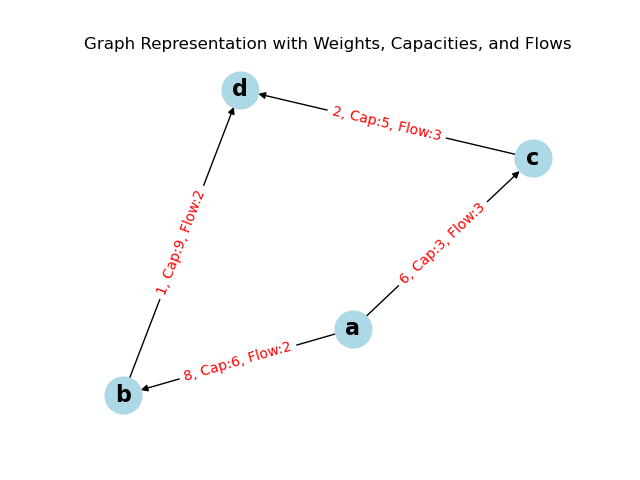

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
# Create a directed graph
G = nx.DiGraph()

# Adding nodes with demand
G.add_node("a", demand=-5)
G.add_node("d", demand=5)

# Adding edges with weights and capacities
G.add_edge("a", "b", weight=8, capacity=6)
# G.add_edge("b", "a", weight=3, capacity=4)

G.add_edge("a", "c", weight=6, capacity=3)
G.add_edge("b", "d", weight=1, capacity=9)
G.add_edge("c", "d", weight=2, capacity=5)

# Solve for minimum cost flow
flowCost, flowDict = nx.capacity_scaling(G)

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=16, font_weight='bold')

# Specify edge labels
edge_labels = {(u, v): f"{d['weight']}, Cap:{d['capacity']}, Flow:{flowDict[u][v]}" for u, v, d in G.edges(data=True)}

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Graph Representation with Weights, Capacities, and Flows")
plt.show()



In [62]:
flowDict

{'a': {'b': 4, 'c': 1}, 'd': {}, 'b': {'a': 0, 'd': 4}, 'c': {'d': 1}}

In [ ]:
from matplotlib import cm

vmax = 1
vmin = 0
t=0
plot_edge_color_value(
    exp2,
    t,
    lambda edge : edge.get_attribute("age",t),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
)

In [6]:

t=0
add_betweenness_QC(exp, t)

Process time 1
Process time 0


c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-12 02:05:00
tot_growth 154564.7184926793


In [11]:
##### bcs = [edge.get_attribute("betweenness_QC", t) for edge in edges]
t = 0
edges = get_all_edges(exp,t)
lengths_0 = [edge.length_um(t) for edge in edges]

t = 1
edges = get_all_edges(exp,t)
lengths_1 = [edge.length_um(t) for edge in edges]

In [88]:
np.sum(lengths_1)-np.sum(lengths_0)

-321885.6320823692

In [12]:
edges = get_all_edges(exp,0)
bcs = [edge.get_attribute("betweenness_QC", t) for edge in edges]
fig,ax = plt.subplots()
ax.hist(np.log10(np.array(bcs)+1),20)
ax.set_yscale("log")

TypeError: 'NoneType' object is not subscriptable

In [20]:
np.log10(np.max(bcs))

4.284265258540658

In [27]:
np.log10(np.max(bcs)/(2*3600)),np.log10(np.min(bcs)/(2*3600))

C:\Users\coren\AppData\Local\Temp\ipykernel_12608\904620796.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.max(bcs)/(2*3600)),np.log10(np.min(bcs)/(2*3600))


(0.4269327621093896, -inf)

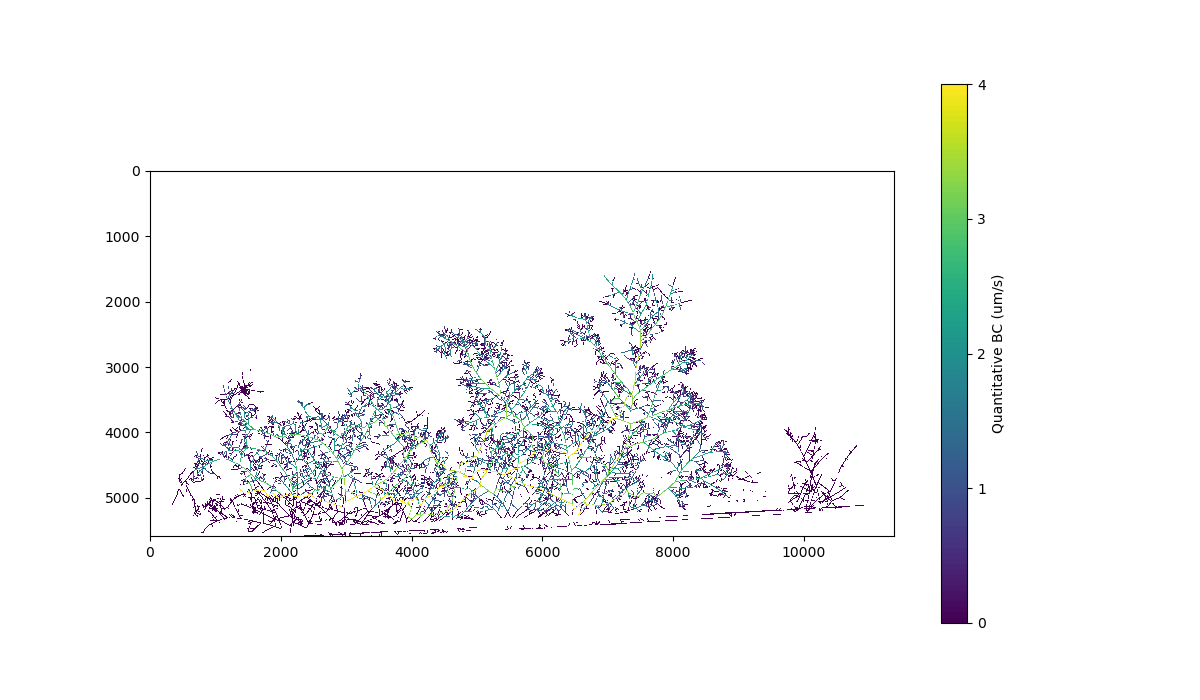

In [8]:
from matplotlib import cm

vmax = 4
vmin = 0
t=0
fig,ax = plot_edge_color_value(
    exp,
    t,
    lambda edge: np.log10(edge.get_attribute("betweenness_QC", t)+1),
    # lambda edge : 2,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(12, 7),
    alpha = 1,
    save_path = "figfull",
    dpi = 400,
    label_colorbar = "Quantitative BC (um/s)"
)

In [18]:
G = exp.nx_graph[0]
paths = dict(nx.all_pairs_shortest_path(G, cutoff=None))


KeyboardInterrupt



In [23]:
t = 0
fun = lambda edge: edge.get_attribute("betweenness_QC", t)
BC_dev = lambda edge: get_derivative(edge, t, fun)

In [24]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import (
    get_abcisse,
    add_betweenness,
    add_hyphal_attributes,
    add_betweenness_QP,
    get_derivative, add_betweenness_QC,
)
direction = {}
for edge in exp.nx_graph[t].edges:
    direction[edge] = BC_dev(Edge(Node(edge[0],exp),Node(edge[1],exp),exp))
nx.set_edge_attributes(exp.nx_graph[t], direction, "direction_flux")


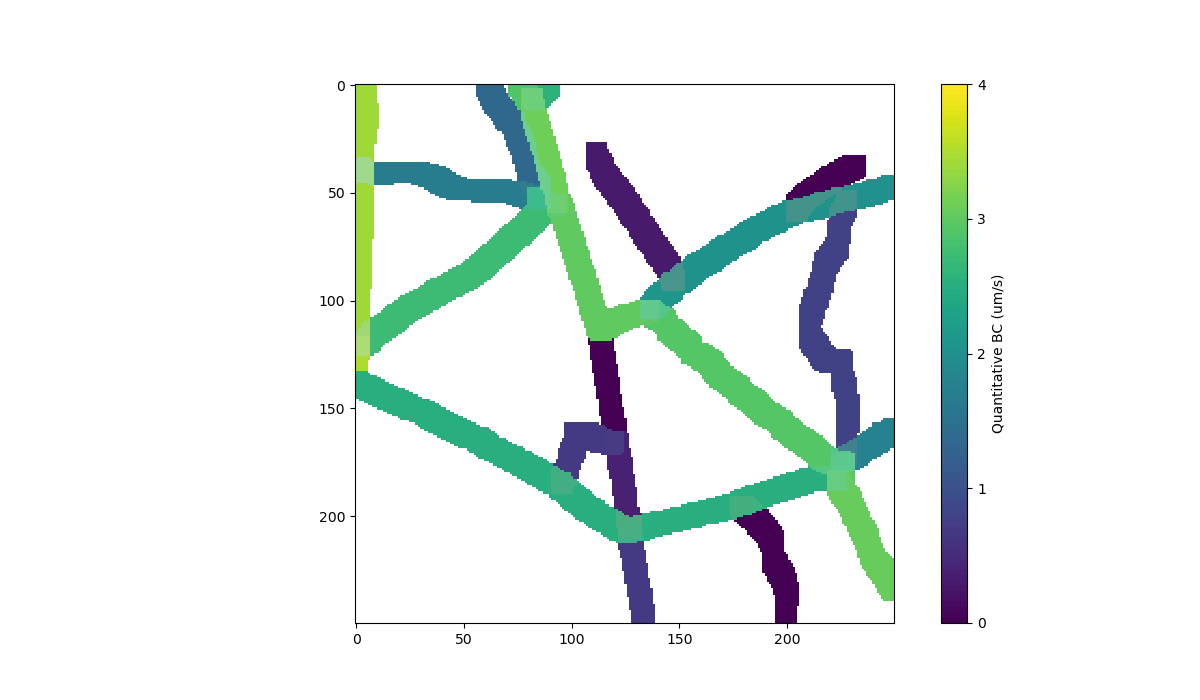

In [41]:
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

vmax = 4
vmin = 0
t=0
downsizing = 5
edges_network = get_all_edges(exp,t)
region = [[3650*downsizing,5450*downsizing],[3900*downsizing,5700*downsizing]]
fig, ax,f = plot_edge_color_value_2(
    exp,
    t,
    lambda edge: np.log10(edge.get_attribute("betweenness_QC", t)+1),
    # lambda edge : 2,
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(12, 7),
    alpha = 1,
    save_path = "figfull",
    dpi = 400,
    label_colorbar = "Quantitative BC (um/s)",
    region = region
)
for edge in edges_network:
    pixels = edge.pixel_list(t)
    if len(pixels)>20:
        center_arrow = f(pixels[len(pixels) // 2])

        begin_arrow = f(pixels[10])
        end_arrow = f(pixels[-10])
        # begin_arrow = edges_network[0].begin.pos(t)
        # end_arrow = edges_network[0].pixel_list(t)[10]
        vector = end_arrow - begin_arrow
        flux_direction = edge.get_attribute("direction_flux", t)
        flux = edge.get_attribute("betweenness_QC", t)
        if flux>1000:
            vector = (
                vector / np.linalg.norm(vector) * 100 / downsizing * (1 - 2 * (flux_direction > 0))
            )
            ax.arrow(center_arrow[1], center_arrow[0], vector[1], vector[0], width=10)

In [15]:
nodes_source,nodes_exp = get_nodes_source_C(exp)
nodes_sink = [node for node in nodes if is_in_ROI_node(node, t)]
nodes_sink = find_lowest_nodes(nodes_sink, t)

Process time 1
Process time 0


c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-12 02:05:00
tot_growth 30846.28134458463


NameError: name 'nodes' is not defined

In [16]:
last_index = 1
segments_length = 5

final_graph = exp.nx_graph[last_index].copy()
node_not_in_ROI = []
for node in final_graph:
    if not is_in_ROI_node(Node(node, exp), last_index):
        node_not_in_ROI.append(node)
final_graph.remove_nodes_from(node_not_in_ROI)

label = max(final_graph.nodes) + 1
graph_segemented_final = nx.empty_graph()
nodes_pos = {}
edges_indexes = {}
segments_index = {}
segments_center_final = []

for edge in final_graph.edges:
    e = Edge(Node(edge[0], exp), Node(edge[1], exp), exp)
    edges_indexes[f"{edge[0]},{edge[1]}"] = []
    pixels = e.pixel_list(last_index)
    length = len(pixels)
    if length < segments_length:
        graph_segemented_final.add_edge(edge[0], edge[1])
        segments_index[f"{edge[0]},{edge[1]}"] = len(segments_center_final)
        edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
        central_point = np.mean(np.array(pixels), axis=0)
        segments_center_final.append(central_point)
        nodes_pos[edge[0]] = pixels[0]
        nodes_pos[edge[1]] = pixels[-1]
        continue

    for i in range(0, length, segments_length):
        sub_list = pixels[i:i+segments_length]
        if i==0:
            graph_segemented_final.add_edge(edge[0], label)
            segments_index[f"{edge[0]},{label}"] = len(segments_center_final)
            edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
            central_point = np.mean(np.array(sub_list), axis=0)
            segments_center_final.append(central_point)
            nodes_pos[edge[0]] = sub_list[0]
            nodes_pos[label] = sub_list[-1]
            label += 1
        elif i+segments_length >= length:
            graph_segemented_final.add_edge(label-1, edge[1])
            segments_index[f"{label-1},{edge[1]}"] = len(segments_center_final)
            edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
            central_point = np.mean(np.array(sub_list), axis=0)
            segments_center_final.append(central_point)
            nodes_pos[edge[1]] = sub_list[-1]
        else:
            graph_segemented_final.add_edge(label-1, label)
            segments_index[f"{label-1},{label}"] = len(segments_center_final)
            edges_indexes[f"{edge[0]},{edge[1]}"].append(len(segments_center_final))
            central_point = np.mean(np.array(sub_list), axis=0)
            segments_center_final.append(central_point)
            nodes_pos[label] = sub_list[-1]
            label += 1

print(f"amount of nodes: {graph_segemented_final.number_of_nodes()}")
print(f"amount of segments: {graph_segemented_final.number_of_edges()}")

array_segments_center_final = np.array(segments_center_final)
shape_segments_center = array_segments_center_final.shape
print(f"Shape array_segments_center_final: {shape_segments_center}")

amount of nodes: 463184
amount of segments: 465836
Shape array_segments_center_final: (465836, 2)


In [17]:
def closest_point(point, points):
    dist_square = np.sum((points-point)**2, axis=1)
    min_index = np.argmin(dist_square)
    return points[min_index], dist_square[min_index]

In [19]:
# When there is a point at a distance of segment under the threshold, the segment is activated (distance in pixel)
# A good distance is (2*segments_length)**2
# Don't forget to square because closest_point give the distance squared
threshold = 10**2

segments_centers = []
segments_min_distances = []
array_segments_center = array_segments_center_final.copy()
for time in reversed(range(last_index+1)):
    print(f"Process time {time}")
    rows = []
    cols = []
    previous_edges = get_all_edges(exp, time)
    for edge in previous_edges:
        p_list = [(round(pixel[0]),round(pixel[1])) for pixel in edge.pixel_list(time)]
        row, col = zip(*p_list)
        rows.extend(row)
        cols.extend(col)
    
    data = np.ones(len(rows))
    points_matrix = sparse.csr_matrix((data, (rows, cols)))
    
    centers_distance = []
    new_centers = array_segments_center.copy()
    for index, center in enumerate(array_segments_center):
        xc, yc = center
        xc, yc = int(xc), int(yc)

        min_x, max_x = max(0, xc-4*segments_length), xc+4*segments_length
        min_y, max_y = max(0, yc-4*segments_length), yc+4*segments_length
        coords = points_matrix[min_x:max_x, min_y:max_y].nonzero()
        coords = np.column_stack(coords)
        if not coords.shape[0]:
            centers_distance.append(32*(segments_length**2))
            continue

        xc -= min_x
        yc -= min_y

        new_center, min_dist = closest_point([xc, yc], coords)
        centers_distance.append(min_dist)
        if min_dist < threshold:
            new_centers[index] = new_center + np.array([min_x, min_y])
    
    array_segments_center = new_centers
    segments_centers.append(new_centers)
    segments_min_distances.append(centers_distance)

segments_min_distances.reverse()
# Index t are the centers of the segments at time t
segments_centers.reverse()

Process time 1
Process time 0


In [20]:
# Amount of segment to look for at in an edge to get the date at which the edge encounter the node
# Depends of how big segments are and what threshold you use
amount_of_border_segment = 7

segments_min_distances_array = np.array(segments_min_distances)
segments_min_distances_array = np.where(segments_min_distances_array<threshold, 1, 0)
segments_time = segments_min_distances_array.argmax(axis=0)

edges_time_interval = {}

for e in final_graph.edges:
    edge = Edge(Node(e[0], exp), Node(e[1], exp), exp)
    segments_indexes = edges_indexes[f"{edge.begin.label},{edge.end.label}"]
    segments_times = np.array([segments_time[index] for index in segments_indexes])

    begin = np.median(segments_times[:amount_of_border_segment])
    if len(segments_times)>amount_of_border_segment:
        end = np.median(segments_times[-amount_of_border_segment:])
    else:
        end = np.median(segments_times)

    edges_time_interval[f"{edge.begin.label},{edge.end.label}"] = (begin, end)

In [ ]:
plt.close("all")
fig, ax1 = plt.subplots(1, 1, figsize=(14, 8)) 

for key, edge in enumerate(graph_segemented_final.edges):
    begin, end = edge
    (y1, x1), (y2, x2) = nodes_pos[begin], nodes_pos[end]
    index = segments_index.get(f"{begin},{end}")
    if index is None:
        index = segments_index[f"{end},{begin}"]
    time = segments_time[index]
    color = cm.viridis(time/last_index)
    if time < 100:
    
        ax1.plot([x1, x2], [y1, y2], c=color)

sm = plt.cm.ScalarMappable(cmap=cm.viridis) 
sm.set_array([]) 
plt.colorbar(sm, ax=ax1) 

plt.xlim(0, 56000)
plt.ylim(0, 30000)
plt.gca().invert_yaxis()

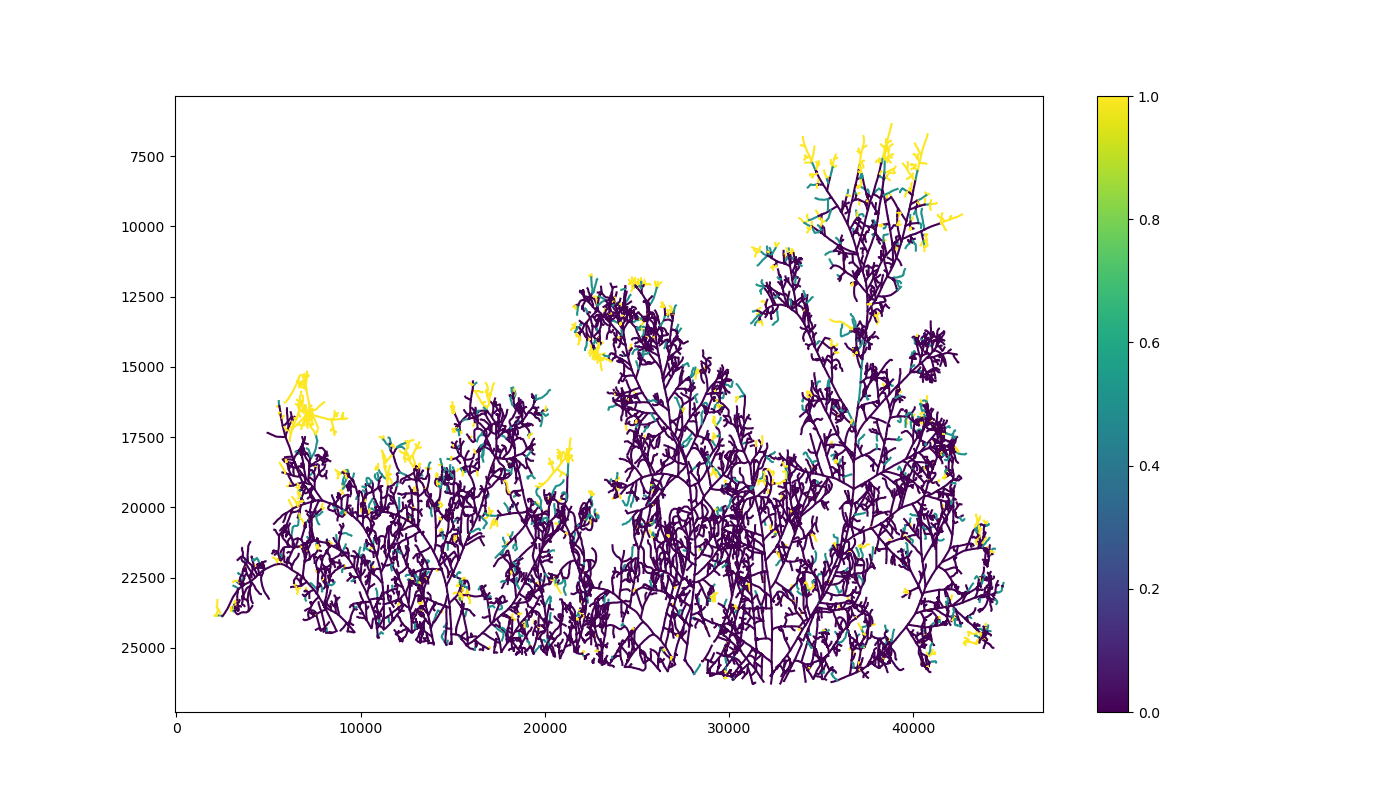

In [21]:
plt.close("all")
fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))

for e in final_graph.edges:
    edge = Edge(Node(e[0], exp), Node(e[1], exp), exp)
    time_interval = edges_time_interval.get(f"{edge.begin.label},{edge.end.label}")
    time = (time_interval[0]+time_interval[1])/2 # type: ignore
    pixels = edge.pixel_list(last_index)
    y, x = zip(*pixels)
    color = cm.viridis(time/last_index)
    plt.plot(x, y, color=color)

sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_array([]) 
plt.colorbar(sm, ax=ax1) 

plt.gca().invert_yaxis()

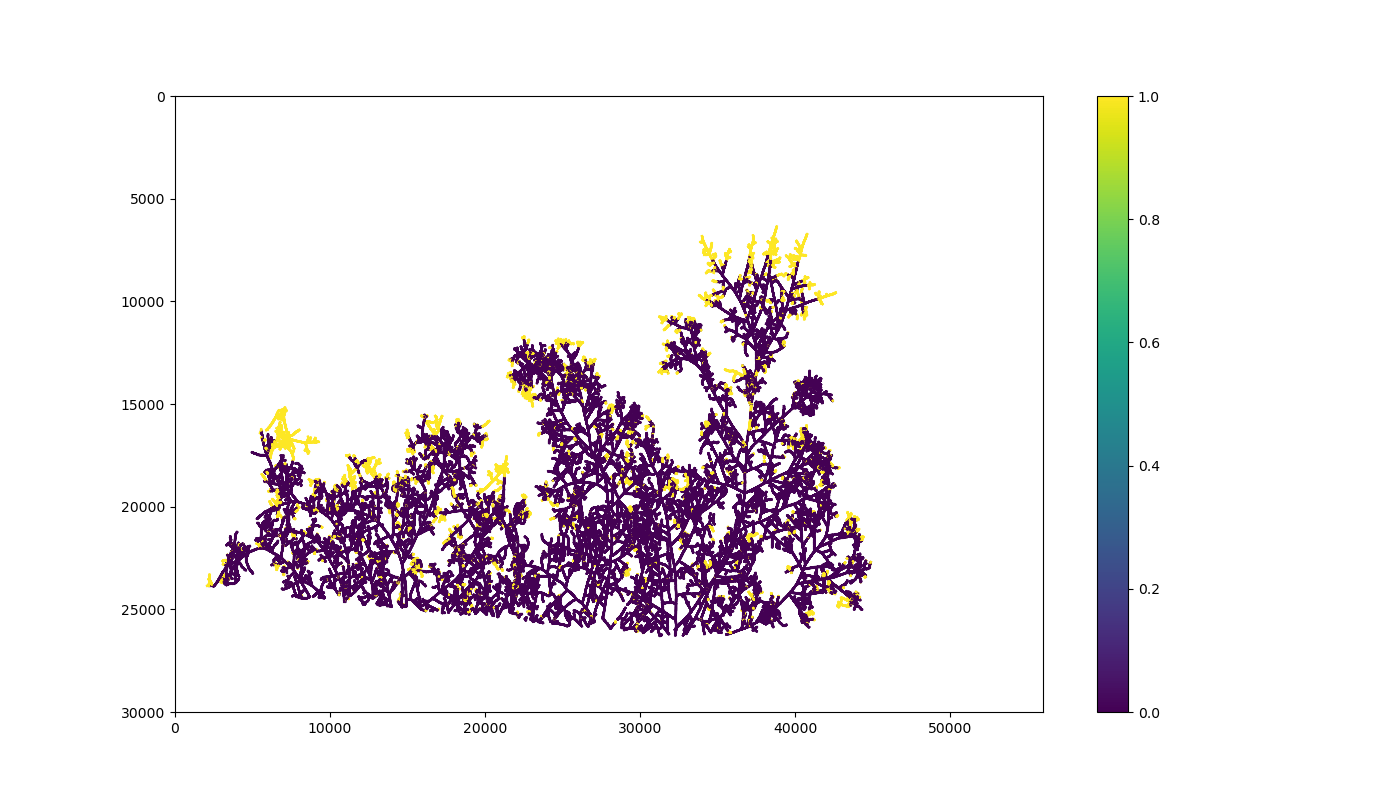

In [23]:
plt.close("all")
fig, ax1 = plt.subplots(1, 1, figsize=(14, 8)) 

for key, edge in enumerate(graph_segemented_final.edges):
    begin, end = edge
    (y1, x1), (y2, x2) = nodes_pos[begin], nodes_pos[end]
    index = segments_index.get(f"{begin},{end}")
    if index is None:
        index = segments_index[f"{end},{begin}"]
    time = segments_time[index]
    color = cm.viridis(time/last_index)
    if time < 100:
    
        ax1.plot([x1, x2], [y1, y2], c=color)

sm = plt.cm.ScalarMappable(cmap=cm.viridis) 
sm.set_array([]) 
plt.colorbar(sm, ax=ax1) 

plt.xlim(0, 56000)
plt.ylim(0, 30000)
plt.gca().invert_yaxis()

In [24]:
exp2.load(exp.folders.iloc[1: 2], suffix="_labeled2")
exp2.nx_graph = [graph_segemented_final]
exp2.positions = [nodes_pos]
pixel_lists = {}
lengths = {}

t = 0
for key, edge in enumerate(graph_segemented_final.edges):
    begin, end = edge
    (y1, x1), (y2, x2) = nodes_pos[begin], nodes_pos[end]
    pixel_lists[edge] = [(y1, x1), (y2, x2)]
    pixel_conversion_factor = 1.725
    lengths[edge] = np.sqrt((y1-y2)**2+(x1-x2)**2)*pixel_conversion_factor

nx.set_edge_attributes(exp2.nx_graph[t], pixel_lists, "pixel_list")
edges = get_all_edges(exp2, 0)
ages = {(edge.begin.label, edge.end.label): get_age(edge) for edge in edges}
nx.set_edge_attributes(exp2.nx_graph[t], ages, "age")
nx.set_edge_attributes(exp2.nx_graph[t], lengths, "length")

c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\functions\image_processing\experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-12 02:05:00


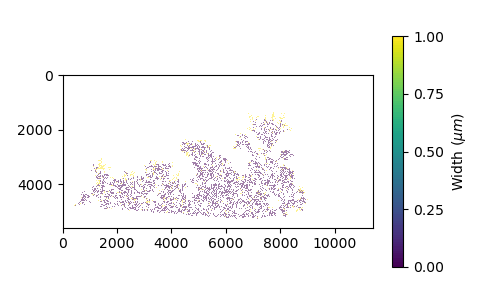

(<Figure size 500x300 with 2 Axes>, <AxesSubplot: >)

In [25]:
from matplotlib import cm

vmax = 1
vmin = 0
t=0
plot_edge_color_value(
    exp2,
    t,
    lambda edge : edge.get_attribute("age",t),
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
)